In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
path,dir,files = next(os.walk('/content/drive/Shareddrives/Machine Learning/DeGreenProject/Dataset/Train/Black Soil'))
file_count = len(files)
print("Number of images: ",file_count)

Number of images:  148


In [ ]:
image_shape = (224, 224)
TRAINING_DIR = "/content/drive/Shareddrives/Machine Learning/DeGreenProject/Dataset/Train"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/content/drive/Shareddrives/Machine Learning/DeGreenProject/Dataset/Test"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(TRAINING_DIR, target_size=image_shape,class_mode='categorical',batch_size=32)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, target_size=image_shape,class_mode='categorical',batch_size=8)

Found 519 images belonging to 5 classes.
Found 212 images belonging to 5 classes.


In [ ]:
base_model = InceptionV3(input_shape=None,
                        include_top=False,
                        weights='imagenet')

# Membekukan lapisan-lapisan di base model
base_model.trainable = False

# Buat model baru di atas MobileNetV2 base
Model = tf.keras.Sequential([
    base_model,

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')  # 5 output neurons untuk 5 kelas dengan aktivasi softmax
])

Model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                

In [ ]:
from tensorflow.keras.optimizers import RMSprop

Model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc') > 0.92 and logs.get('acc') > 0.92): # Experiment with changing this value
      print("\nReached 95% Validation Accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history = Model.fit(train_generator, epochs = 50,
                          validation_data=validation_generator, callbacks= [callbacks])

Epoch 1/50
17/17 [==============================] - 128s 7s/step - loss: 2.6654 - acc: 0.3969 - val_loss: 1.3522 - val_acc: 0.4292
Epoch 2/50
17/17 [==============================] - 115s 7s/step - loss: 1.2136 - acc: 0.5260 - val_loss: 1.1653 - val_acc: 0.5755
Epoch 3/50
17/17 [==============================] - 100s 6s/step - loss: 1.0384 - acc: 0.5742 - val_loss: 1.0910 - val_acc: 0.5708
Epoch 4/50
17/17 [==============================] - 106s 6s/step - loss: 0.8508 - acc: 0.6590 - val_loss: 1.0284 - val_acc: 0.5519
Epoch 5/50
17/17 [==============================] - 115s 7s/step - loss: 0.8352 - acc: 0.6879 - val_loss: 0.7710 - val_acc: 0.6934
Epoch 6/50
17/17 [==============================] - 114s 7s/step - loss: 0.7558 - acc: 0.6956 - val_loss: 0.7443 - val_acc: 0.7075
Epoch 7/50
17/17 [==============================] - 119s 7s/step - loss: 0.7561 - acc: 0.7033 - val_loss: 0.6257 - val_acc: 0.7830
Epoch 8/50
17/17 [==============================] - 102s 6s/step - loss: 0.6599 - a

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


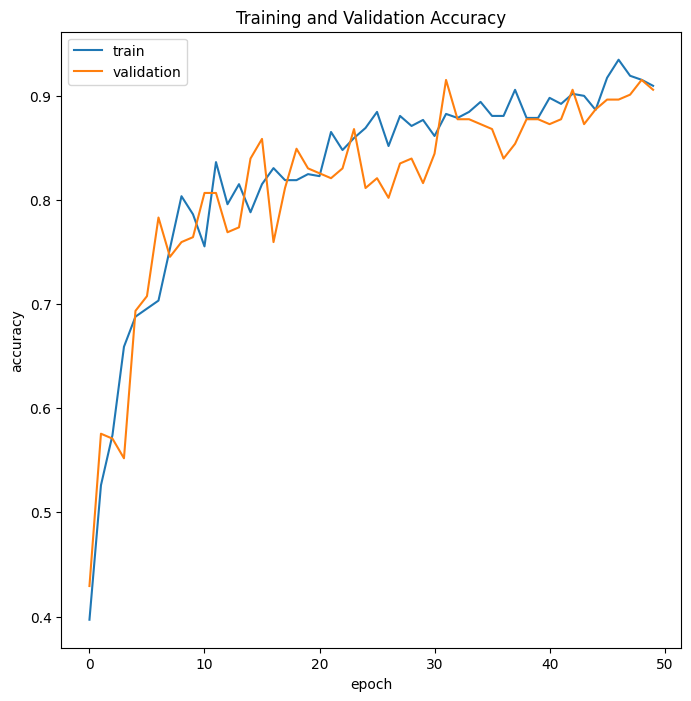

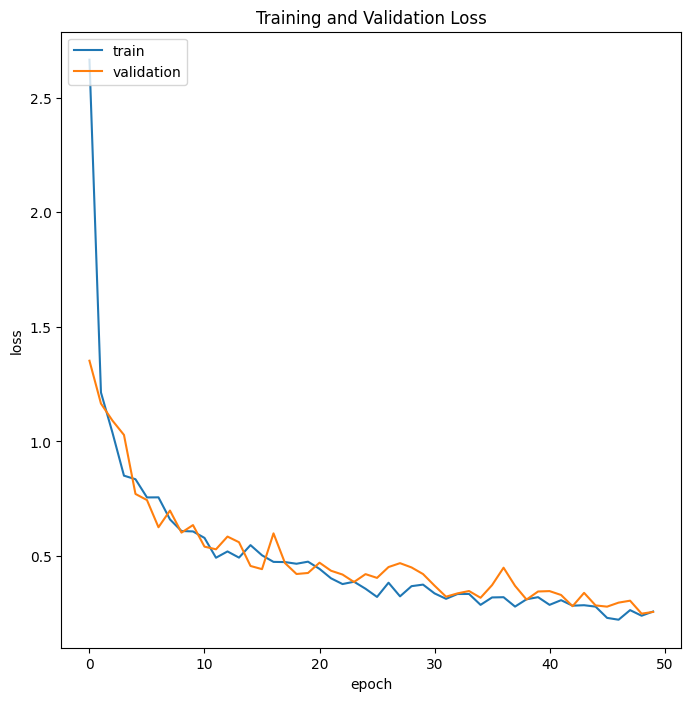

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.figure(figsize=(8, 8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


# summarize history for loss
plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(224, 224))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = Model.predict(images, batch_size=10)

  print(classes[0])

  if classes[0][0]>0.7:
    print(fn + " is a Aluvial Soil")
  elif classes[0][1]>0.7:
    print(fn + " is a Black Soil")
  elif classes[0][2]>0.7:
    print(fn + " is a Cinder Soil")
  elif classes[0][3]>0.7:
    print(fn + " is a Clay Soil")
  else:
    print(fn + " is a Red Soil")

Saving alluvial.jpg to alluvial.jpg
1/1 [==============================] - 0s 136ms/step
[1.5572067e-01 5.3322385e-03 5.2579015e-04 2.4653302e-04 8.3817476e-01]
alluvial.jpg is a Red Soil


In [ ]:
Model.save('soil_classification_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
